In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

### Data preparation and model configuration

In [4]:
# ============= Import required packaages ==============
# Import all custom variables and modules

from custom_classes_defs_revised.preprocessing import *
#from custom_classes_defs_revised.unet0 import *
from custom_classes_defs_revised.Unet_like import *

#from custom_classes_defs.setup import *  
#from custom_classes_defs.preprocessing import *
#from custom_classes_defs.Unet_like import * 
#from custom_classes_defs.unet import *   
# from custom_classes_defs.fnet import * 
# from custom_classes_defs.fnet1 import *
# from custom_classes_defs.hed import *

import keras
import numpy as np

from keras.utils import plot_model

RND_STATE = 247
BATCH_SIZE = 256


keras.utils.set_random_seed(RND_STATE)

INTERACTIVE_SESSION = True

# import keras_tuner as kt
# -------------------------------------------------------

2024-05-29 23:38:27.632132: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 23:38:29.447826: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 23:38:29.448647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 23:38:29.658417: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-29 23:38:30.157133: I tensorflow/core/platform/cpu_feature_guar

In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

#if NUM_GPU:
#    # print GPU info
#    !nvidia-smi

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1


In [6]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
time_start= time.time()

seis_path = '../data_thebe/seismic/'
label_path = '../data_thebe/fault/'

thebe_data = Thebe(seis_path,label_path)

train_dataset = thebe_data.data_generator(sub_group='train',batch_size = BATCH_SIZE, cache=True)
val_dataset = thebe_data.data_generator(sub_group='val',batch_size= BATCH_SIZE, cache= True)
test_dataset = thebe_data.data_generator(sub_group='test',as_numpy=True, cache=True)

print("Train Dataset:", train_dataset)

print("Size of training data: {}".format(thebe_data.train_size))
print("Size of validation data: {}".format(thebe_data.validation_size))
print("Size of test data: {}".format(thebe_data.test_size)) 

print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-time_start) / 60))

	Data preparation and model configurations
-------------------------------------------------------


2024-05-29 23:39:49.208335: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37787 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:86:00.0, compute capability: 8.0


Train Dataset: <CacheDataset element_spec=(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None))>
Size of training data: 181029
Size of validation data: 64317
Size of test data: 66077
...elapsed time: ___ 0.85 minutes___


In [7]:
# Model configurations
conf = model_config(
    epochs=100,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    save_path='./output/unetlike',
    img_shape=thebe_data.img_size,
    target_size=thebe_data.img_size,
    threshold=thebe_data.threshold,
    pos_label=thebe_data.pos_label,
    train_size=thebe_data.train_size,
    test_size=thebe_data.test_size,
    new_training_session=True,
    multiple_gpu_device=(NUM_GPU>1),
    validation_size=thebe_data.validation_size
)

callbacks = conf.callbacks(
    chkpt_monitor='val_f1_score', 
    es_monitor='val_loss',
    es_patience=100, 
    lr_monitor='val_loss',
)

conf.set( validation_data=val_dataset,  callbacks=callbacks )
m1 = f1_score(positive_label=thebe_data.pos_label, threshold=thebe_data.threshold)
conf.set(
    'compile',
    optimizer=tf.keras.optimizers.Adam(1e-3), 
    metrics= ['accuracy', m1]
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

             NUM_GPU: 1
        augmentation: False
        channels_dim: (1, 1)
        compile_args:
                     optimizer: <class 'keras.src.optimizers.adam.Adam'>
                          loss: binary_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
           img_shape: (96, 96)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 1
           save_path: ./output/unetlike
             scaling: 1
         target_size: (96, 96)
           test_size: 66077
           threshold: 0.5
          train_size: 181029
       training_args:
                        epochs: 100
                    batch_size:

### Build model

In [8]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():

        conf = model_config(
            epochs=100,
            batch_size=BATCH_SIZE,
            shuffle=True,
            scaling=1,
            save_path='./output/unetlike',
            img_shape=thebe_data.img_size,
            target_size=thebe_data.img_size,
            threshold=thebe_data.threshold,
            pos_label=thebe_data.pos_label,
            train_size=thebe_data.train_size,
            test_size=thebe_data.test_size,
            new_training_session=True,
            multiple_gpu_device=None,
            validation_size=thebe_data.validation_size
        )

        callbacks = conf.callbacks(
            chkpt_monitor='val_f1_score', 
            es_monitor='val_loss',
            es_patience=100, 
            lr_monitor='val_loss',
        )

        conf.set( validation_data=val_dataset,  callbacks=callbacks )
        m1 = f1_score(positive_label=thebe_data.pos_label, threshold=thebe_data.threshold)
        conf.set(
            'compile',
            metrics= ['accuracy', m1]
        )

        m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        #m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    #m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 2,057,825
Total trainable wieghts: 2,054,049
Total non-trainable wieghts: 3,776


### Train the model



	Train unet model
-------------------------------------------------------
Model training...


2024-05-29 23:40:54.351805: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-NET/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2024-05-29 23:40:56.113449: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


2024-05-29 23:41:14.724186: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f277c3e1620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-29 23:41:14.724260: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-05-29 23:41:14.877471: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1717018876.116158 3992081 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 51: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



Epoch 61: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.



Epoch 71: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.



Epoch 81: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.



Epoch 91: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.


training elapsed time: ___134.55___ minutes
...training completed!


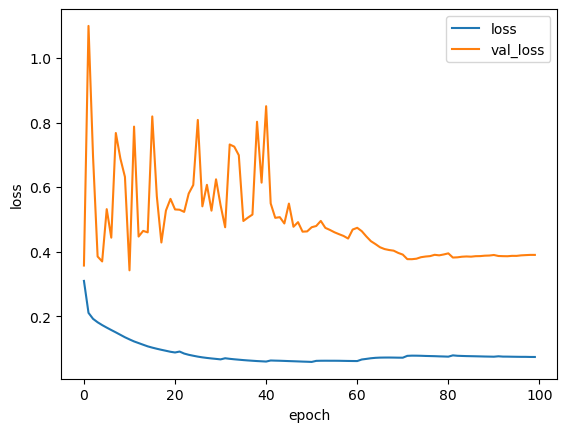

Loading time used 134.58556300401688 mins


In [9]:
time_start= time.time()
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=train_dataset, 
        plot_history=INTERACTIVE_SESSION
)


time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')



	Train unet model
-------------------------------------------------------
Model training...



Epoch 11: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.



Epoch 21: ReduceLROnPlateau reducing learning rate to 1e-06.


training elapsed time: ___129.47___ minutes
...training completed!


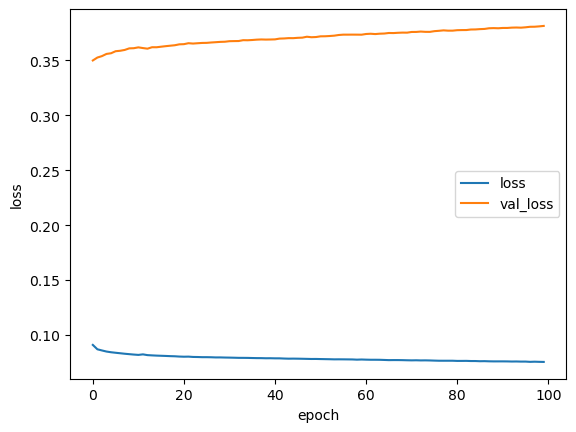

Loading time used 129.48035744825998 mins


In [10]:
time_start= time.time()

print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=train_dataset, 
        plot_history=INTERACTIVE_SESSION
)

time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')

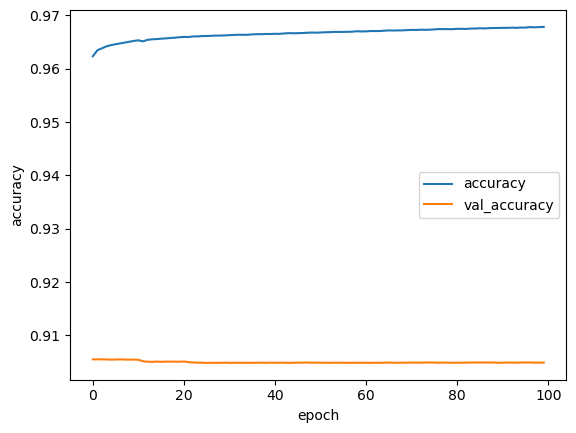

In [11]:
show_convergence(train_history.history, ['accuracy','val_accuracy'])

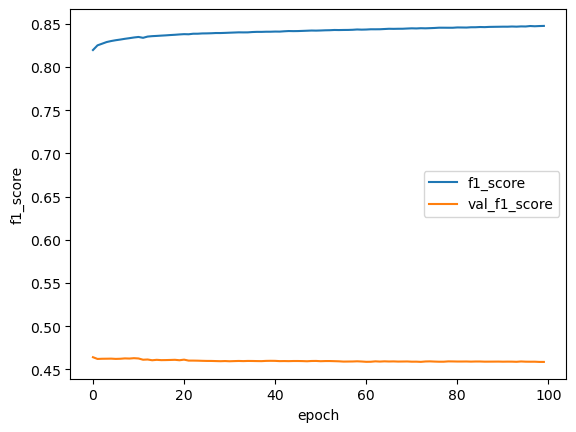

In [12]:
show_convergence(train_history.history, ['f1_score','val_f1_score'])

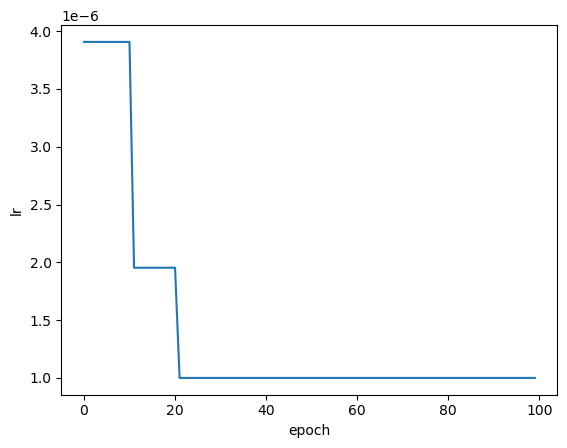

In [13]:
show_convergence(train_history.history, 'lr')

### Visualize predictions

In [14]:
# check the pairs of ori images and labels on val dataset

#display_sample_images(val_dataset[0], val_dataset[1],(96,96))

In [15]:
#time_start= time.time()
#y_preds = model.predict(test_dataset[0])

#time_end = (time.time()-time_start)/60
#print(f'Loading time used {time_end} mins')

In [16]:
#display_sample_images(y_preds, test_dataset[1],(96,96))

In [17]:
#time_start= time.time()

#print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))

#model.evaluate(x=test_dataset)
#time_end = (time.time()-time_start)/60
#print(f'Loading time used {time_end} mins')

In [18]:
# Using scikit-learn
#scores = m_obj.evaluate_sklearn(test_dataset, y_preds,report=True)
#print(scores)
